In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import unicodedata
import sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy import sparse
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import accuracy_score

In [74]:
# Read in the original dataframes
data1 = pd.read_csv('True.csv')
data2 = pd.read_csv('Fake.csv')
# Add columns to indicate the target variable
data1['tag'] = 'True'
data2['tag'] = 'Fake'
# Combine the two dataframes into one
df = data1.append(data2, ignore_index = True, sort = False)
df2 = df[df['date'].str.startswith('https') == False]
df3 = df2[df2['date'].str.startswith('MSNBC') == False]
df4['date'] = pd.to_datetime(df3['date'].str.strip())

In [5]:
df4

,title,text,subject,date,tag
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,True
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,Fake
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,Fake
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,Fake
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,Fake


Text(0, 0.5, 'Count')

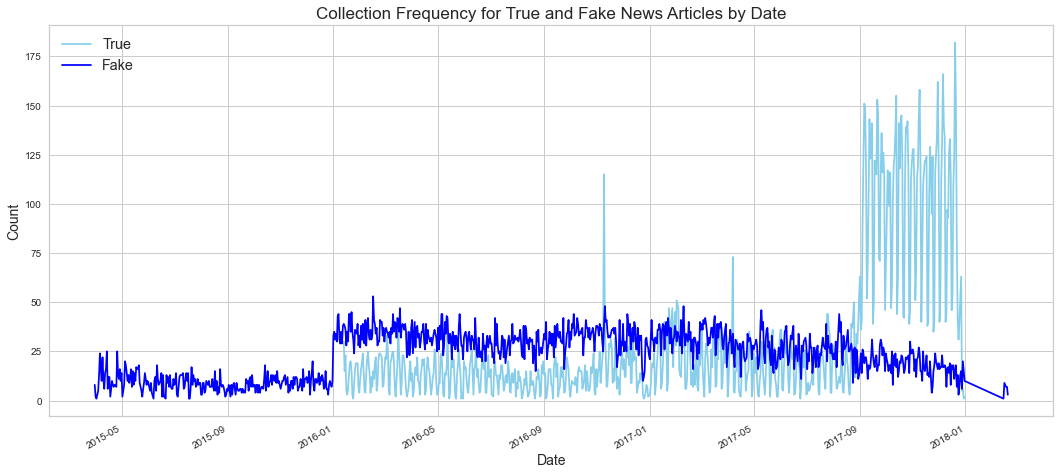

In [151]:
plt.figure(figsize = (18,8))
df4.groupby('tag').date.value_counts()[0].plot(color = 'skyblue')
df4.groupby('tag').date.value_counts()[1].plot(color = 'blue')
plt.legend(labels = ['True', 'Fake'], fontsize = 'large', loc = 2)
plt.title('Collection Frequency for True and Fake News Articles by Date', fontsize = 17)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

In [7]:
search = 'Reuters'
df[df['text'].str.contains(search)].tag.value_counts()

True    21378
Fake      311
Name: tag, dtype: int64

Text(0.5, 1.0, 'Subject of News Count by Credibility')

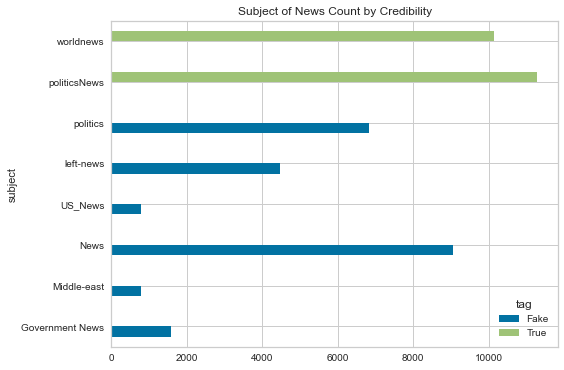

In [136]:
df.groupby('tag').subject.value_counts().unstack(0).plot.barh(figsize = (8,6))
plt.title('Subject of News Count by Credibility')

Text(0.5, 1.0, 'Count of News Articles by Credibility')

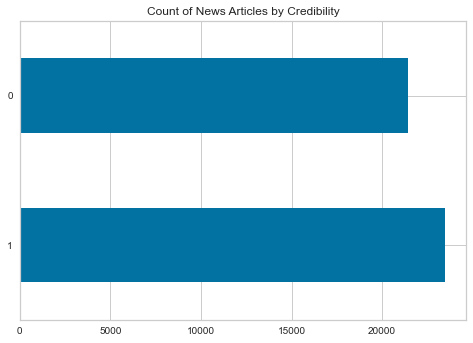

In [137]:
df4['tag'].value_counts().plot.barh()
plt.title('Count of News Articles by Credibility')

In [10]:
len(df)

44898

In [11]:
df['tag'].value_counts()

Fake    23481
True    21417
Name: tag, dtype: int64

In [12]:
search = 'MSNBC'
df[df['date'].str.startswith(search)]

,title,text,subject,date,tag
40350,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,Fake


In [142]:
search = 'Reuters'
df[df['text'].str.contains(search)]

,title,text,subject,date,tag
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True
...,...,...,...,...,...
44692,False Alarm or Psy-Op? LAX ‘Active Shooter’ Sp...,Shawn Helton 21st Century WireAnother active-s...,Middle-east,"September 3, 2016",Fake
44725,DALLAS MAIDAN: Staged Snipers Designed to Infl...,"Daily Shooter 21st Century WireLast night, a h...",Middle-east,"July 8, 2016",Fake
44761,Peace Prize President Obama Approved $200 Bill...,21st Century Wire says The military industrial...,Middle-east,"May 24, 2016",Fake
44776,‘To Stop Clinton’: The TOP Reason Americans Wi...,21st Century Wire says A greater percentage of...,Middle-east,"May 6, 2016",Fake


In [14]:
search = 'http'
df[df['date'].str.contains(search)]

,title,text,subject,date,tag
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,Fake
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,Fake
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,Fake
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,Fake
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,Fake
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,Fake
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,Fake
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,Fake


In [15]:
x = df4.iloc[:,0:4]
y = df4.iloc[:,4]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, random_state = 123, stratify = y)

In [16]:
def process_text(col):
    punctuation = '[^\w\s]'
    copy = col.copy()
    col2 = copy.str.lower().str.strip().str.replace(punctuation, '')
    col3 = col2.apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    stop_words.add('Reuters')
    col4 =  col3.apply(lambda x: [y for y in x if not y in stop_words])
    porter = PorterStemmer()
    col5 = col4.apply(lambda x: [porter.stem(y) for y in x])
    col6 = joined_words = [' '.join(line) for line in col5]
    return col6

In [17]:
x_train_midproc = x_train.copy()
x_train_midproc.title = process_text(x_train.title)
x_train_midproc.text = process_text(x_train.text)
x_train_midproc['all_text'] = x_train_midproc.title + ' ' + x_train_midproc.text

In [19]:
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(x_train_midproc.all_text)

In [21]:
x_test_midproc = x_test.copy()
x_test_midproc.title = process_text(x_test.title)
x_test_midproc.text = process_text(x_test.text)
x_test_midproc['all_text'] = x_test_midproc.title + ' ' + x_test_midproc.text

In [22]:
vectors_test = vectorizer.transform(x_test_midproc.all_text)
y_train_final = y_train.replace({'True' : 0, 'Fake' : 1})
y_test_final = y_test.replace({'True' : 0, 'Fake' : 1})

In [27]:
clf = MultinomialNB()
clf.fit(vectors_train, y_train.replace({'True' : 0, 'Fake' : 1}))
print('recall:', np.mean(cross_val_score(clf, vectors_train, y_train_final, cv = 5, scoring = 'recall')))
print('accuracy:', np.mean(cross_val_score(clf, vectors_train, y_train_final, cv = 5, scoring = 'accuracy')))

recall: 0.9384758010379283
accuracy: 0.9359591488508763


In [28]:
logreg = LogisticRegression()
logreg.fit(vectors_train, y_train.replace({'True' : 0, 'Fake' : 1}))
print('recall:', np.mean(cross_val_score(logreg, vectors_train, y_train_final, cv = 5, scoring = 'recall')))
print('accruacy:', np.mean(cross_val_score(logreg, vectors_train, y_train_final, cv = 5, scoring = 'accuracy')))

recall: 0.9838663150964344
accruacy: 0.9849996632114559


In [29]:
RF = RandomForestClassifier()
RF.fit(vectors_train, y_train.replace({'True' : 0, 'Fake' : 1}))
print('recall:', np.mean(cross_val_score(RF, vectors_train, y_train_final, cv = 5, scoring = 'recall')))
print('accruacy:', np.mean(cross_val_score(RF, vectors_train, y_train_final, cv = 5, scoring = 'accuracy')))

recall: 0.9843207314554233
accruacy: 0.9863363498147398


In [139]:
print('baseline logreg recall: .984, baseline logreg acc: .985')
print('Unchanged after the removal of Reuters')

baseline logreg recall: .984, baseline logreg acc: .985
Unchanged after the removal of Reuters


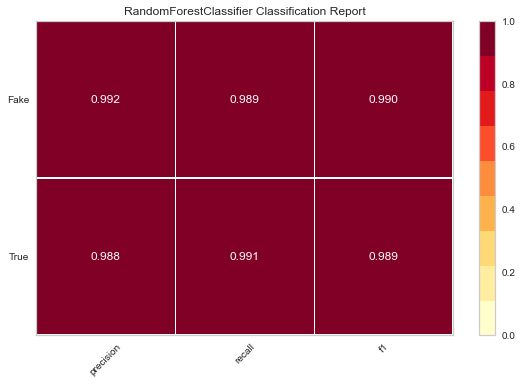

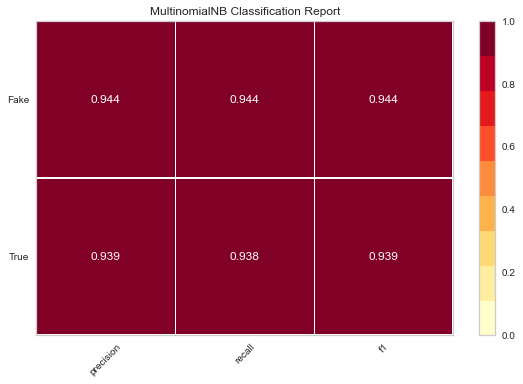

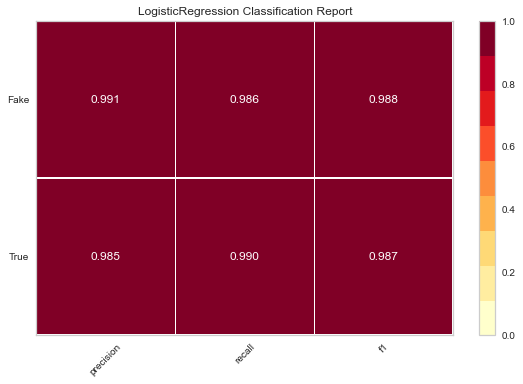

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [128]:
classes = ['True', 'Fake']
RF_viz = ClassificationReport(RF, classes = classes)
RF_viz.score(vectors_test, y_test_final)
RF_viz.show()

clf_viz = ClassificationReport(clf, classes = classes)
clf_viz.score(vectors_test, y_test_final)
clf_viz.show()

logreg_viz = ClassificationReport(logreg, classes = classes)
logreg_viz.score(vectors_test, y_test_final)
logreg_viz.show()

In [134]:
print('RF accuracy:', round(RF_viz.score_, 3))
print('clf accuracy:', round(clf_viz.score_, 3))
print('logreg accuracy:', round(logreg_viz.score_, 3))

RF accuracy: 0.99
clf accuracy: 0.941
logreg accuracy: 0.988
